In [1]:
import  numpy as np
from statistics import mean
import pandas as pd
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from scipy import interp

import warnings
warnings.filterwarnings('ignore')


data = pd.read_csv('features_30_sec.csv')
n_classes=10

X =  data.drop(["label","filename"],axis = 1)
y = data["label"]

### Music Generes Datasets

In [2]:
data

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,rock.00095.wav,661794,0.352063,0.080487,0.079486,0.000345,2008.149458,282174.689224,2106.541053,88609.749506,...,45.050526,-13.289984,41.754955,2.484145,36.778877,-6.713265,54.866825,-1.193787,49.950665,rock
996,rock.00096.wav,661794,0.398687,0.075086,0.076458,0.000588,2006.843354,182114.709510,2068.942009,82426.016726,...,33.851742,-10.848309,39.395096,1.881229,32.010040,-7.461491,39.196327,-2.795338,31.773624,rock
997,rock.00097.wav,661794,0.432142,0.075268,0.081651,0.000322,2077.526598,231657.968040,1927.293153,74717.124394,...,33.597008,-12.845291,36.367264,3.440978,36.001110,-12.588070,42.502201,-2.106337,29.865515,rock
998,rock.00098.wav,661794,0.362485,0.091506,0.083860,0.001211,1398.699344,240318.731073,1818.450280,109090.207161,...,46.324894,-4.416050,43.583942,1.556207,34.331261,-5.041897,47.227180,-3.590644,41.299088,rock


In [3]:
X

,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,3805.839606,...,0.752740,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035
1,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,3550.522098,...,0.927998,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282
2,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,3042.260232,...,2.451690,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025
3,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,2184.745799,...,0.780874,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339
4,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,3579.757627,...,-4.520576,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,661794,0.352063,0.080487,0.079486,0.000345,2008.149458,282174.689224,2106.541053,88609.749506,4253.557033,...,1.789867,45.050526,-13.289984,41.754955,2.484145,36.778877,-6.713265,54.866825,-1.193787,49.950665
996,661794,0.398687,0.075086,0.076458,0.000588,2006.843354,182114.709510,2068.942009,82426.016726,4149.338328,...,3.739020,33.851742,-10.848309,39.395096,1.881229,32.010040,-7.461491,39.196327,-2.795338,31.773624
997,661794,0.432142,0.075268,0.081651,0.000322,2077.526598,231657.968040,1927.293153,74717.124394,4031.405321,...,1.838090,33.597008,-12.845291,36.367264,3.440978,36.001110,-12.588070,42.502201,-2.106337,29.865515
998,661794,0.362485,0.091506,0.083860,0.001211,1398.699344,240318.731073,1818.450280,109090.207161,3015.631004,...,-2.812176,46.324894,-4.416050,43.583942,1.556207,34.331261,-5.041897,47.227180,-3.590644,41.299088


In [4]:
y

0      blues
1      blues
2      blues
3      blues
4      blues
       ...  
995     rock
996     rock
997     rock
998     rock
999     rock
Name: label, Length: 1000, dtype: object

### Split dataset

In [5]:
list(y.drop_duplicates().values)

['blues',
 'classical',
 'country',
 'disco',
 'hiphop',
 'jazz',
 'metal',
 'pop',
 'reggae',
 'rock']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.2,random_state = 56)

y_train_roc = label_binarize(y_train, classes=list(y.drop_duplicates().values))
y_test_roc = label_binarize(y_test, classes=list(y.drop_duplicates().values))
cv = StratifiedKFold(n_splits=10, shuffle = True, random_state = 56)

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y_test)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}


In [7]:
y_train_roc

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]])

In [8]:
y_test

33      blues
779       pop
34      blues
566      jazz
24      blues
        ...  
823    reggae
547      jazz
784       pop
687     metal
709       pop
Name: label, Length: 200, dtype: object

In [9]:
y_test_roc

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]])


### Logistic Regression

In [10]:
clf_logreg = LogisticRegression()
clf_logreg.fit(X_train, y_train)
y_pred_class_logreg = cross_val_predict(clf_logreg, X_test, y_test, cv = cv)
y_pred_prob_logreg = cross_val_predict(clf_logreg, X_test, y_test, cv = cv, method="predict_proba")

### SGD Classifier

In [11]:
clf_SGD = SGDClassifier()
clf_SGD.fit(X_train, y_train)
y_pred_class_SGD = cross_val_predict(clf_SGD, X_test, y_test, cv = cv)
y_pred_prob_SGD = cross_val_predict(clf_SGD, X_test, y_test, cv = cv, method="decision_function")

### Random Forest Classifier

In [12]:
clf_rfc = RandomForestClassifier()
clf_rfc.fit(X_train, y_train)
y_pred_class_rfc = cross_val_predict(clf_rfc, X_test, y_test, cv = cv)
y_pred_prob_rfc = cross_val_predict(clf_rfc, X_test, y_test, cv = cv, method="predict_proba")

### K Neighbors Classifier

In [13]:
clf_knn = KNeighborsClassifier()
clf_knn.fit(X_train, y_train)
y_pred_class_knn = cross_val_predict(clf_knn, X_test, y_test, cv = cv)
y_pred_prob_knn = cross_val_predict(clf_knn, X_test, y_test, cv = cv, method="predict_proba")

### Neural network
#### Feature extraction

In [14]:
from tensorflow import keras

# from sklearn.preprocessing import LabelEncoder
# convert = LabelEncoder()
# y2 = convert.fit_transform(y)

from sklearn.preprocessing import LabelBinarizer # one hot encoding
label_as_binary = LabelBinarizer()
y2 = label_as_binary.fit_transform(y)

In [15]:
y2

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

In [16]:
# scaling features
from sklearn.preprocessing import StandardScaler
fit = StandardScaler()
X2 = fit.fit_transform(np.array(X, dtype=float))

In [17]:
X2

array([[-0.13282213, -0.35013678,  0.31258717, ..., -0.30059734,
         0.60406407, -0.51298758],
       [-0.13282213, -0.46248155,  1.11757233, ..., -0.40708699,
         0.42412706, -0.53842129],
       [-0.13282213, -0.18422456, -0.13770124, ..., -0.52729705,
        -0.29618888, -0.8749539 ],
       ...,
       [-0.13282213,  0.65463736, -1.43198917, ..., -0.63865065,
        -0.26361549, -0.89060474],
       [-0.13282213, -0.19833855,  0.66814351, ..., -0.5114848 ,
        -0.65064889, -0.63768256],
       [-0.13282213, -0.2483391 , -0.05894495, ...,  0.16033426,
         0.5868411 , -0.4526752 ]])

In [18]:
X_train2, x_test2, Y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=56)

In [19]:
print(X_train2.shape, Y_train2.shape)

(800, 58) (800, 10)


In [20]:
print(x_test2.shape, y_test2.shape)

(200, 58) (200, 10)


#### Building model

In [21]:
# CNN
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential()

model.add(Dense(512,input_shape=(X_train2.shape[1],), activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(256,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(64,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(10,activation='softmax'))

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               30208     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                8

In [23]:

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

In [24]:
loss_object = keras.losses.CategoricalCrossentropy()
optimizer = keras.optimizers.Adam()

model.compile(
    loss=loss_object,
    optimizer=optimizer,
    metrics=METRICS)

In [25]:
earlystop = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=10,min_delta=0.0001)
modelcheck = ModelCheckpoint('best_model.hdf5',monitor='val_accuracy',verbose=1,save_best_only=True,mode='max')

In [26]:
history = model.fit(X_train2, Y_train2,
                    validation_data=(x_test2, y_test2),
                    epochs=200,
                    callbacks=[earlystop,modelcheck],
                    batch_size=128)

Epoch 1/200
1/7 [===>..........................] - ETA: 13s - loss: 2.3096 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 1152.0000 - fn: 128.0000 - accuracy: 0.9000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5204
Epoch 00001: val_accuracy improved from -inf to 0.90450, saving model to best_model.hdf5
7/7 [==============================] - 3s 195ms/step - loss: 2.1742 - tp: 3.0000 - fp: 0.0000e+00 - tn: 7200.0000 - fn: 797.0000 - accuracy: 0.9004 - precision: 1.0000 - recall: 0.0037 - auc: 0.6357 - val_loss: 1.8692 - val_tp: 10.0000 - val_fp: 1.0000 - val_tn: 1799.0000 - val_fn: 190.0000 - val_accuracy: 0.9045 - val_precision: 0.9091 - val_recall: 0.0500 - val_auc: 0.7977
Epoch 2/200
1/7 [===>..........................] - ETA: 0s - loss: 1.9025 - tp: 5.0000 - fp: 1.0000 - tn: 1151.0000 - fn: 123.0000 - accuracy: 0.9031 - precision: 0.8333 - recall: 0.0391 - auc: 0.7554
Epoch 00002: val_accuracy improved from 0.90450 to 0.91650, saving model to best_model.hdf5
7/7 [=================

In [27]:
# history.history

7/7 - 0s - loss: 1.0060 - tp: 141.0000 - fp: 41.0000 - tn: 1759.0000 - fn: 59.0000 - accuracy: 0.9500 - precision: 0.7747 - recall: 0.7050 - auc: 0.9560 - 31ms/epoch - 4ms/step
25/25 - 1s - loss: 0.0709 - tp: 783.0000 - fp: 5.0000 - tn: 7195.0000 - fn: 17.0000 - accuracy: 0.9972 - precision: 0.9937 - recall: 0.9787 - auc: 0.9999 - 1s/epoch - 44ms/step


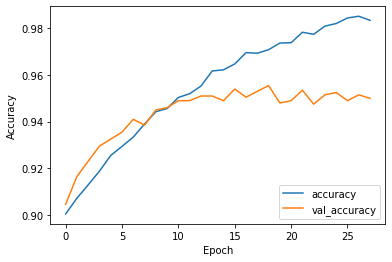

In [28]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

test_loss, test_tp, test_fp, test_tn, test_fn, test_acc, test_precision, test_recall, test_auc = model.evaluate(x_test2,  y_test2, verbose=2)
train_loss, train_tp, train_fp, train_tn, train_fn, train_acc, train_precision, train_recall, train_auc = model.evaluate(X_train2,  Y_train2, verbose=2)

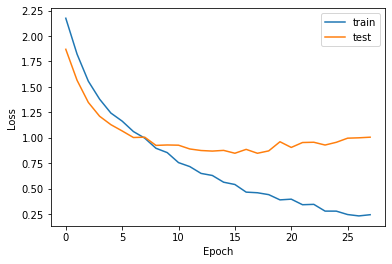

In [29]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [30]:
from sklearn.base import BaseEstimator
import numpy as np

class BaseClassifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

base_clf = BaseClassifier()
cross_val_score(base_clf, X_train, y_train, cv=10, scoring="accuracy").mean()

0.0

### Accuracy

In [31]:
acc_logreg = cross_val_score(clf_logreg, X_test, y_test, cv = cv, scoring = 'accuracy').mean()
acc_SGD = cross_val_score(clf_SGD, X_test, y_test, cv = cv, scoring = 'accuracy').mean()
acc_rfc = cross_val_score(clf_rfc, X_test, y_test, cv = cv, scoring = 'accuracy').mean()
acc_knn = cross_val_score(clf_knn, X_test, y_test, cv = cv, scoring = 'accuracy').mean()
acc_cnn = test_acc

In [32]:
acc_logreg, acc_SGD, acc_rfc, acc_knn, acc_cnn

(0.255, 0.155, 0.65, 0.195, 0.949999988079071)

### Log loss

In [33]:
logloss_logreg = cross_val_score(clf_logreg, X_test, y_test, cv = cv, scoring = 'neg_log_loss').mean()
logloss_rfc = cross_val_score(clf_rfc, X_test, y_test, cv = cv, scoring = 'neg_log_loss').mean()
logloss_knn = cross_val_score(clf_knn, X_test, y_test, cv = cv, scoring = 'neg_log_loss').mean()

from sklearn.calibration import CalibratedClassifierCV

new_clf_SGD = CalibratedClassifierCV(clf_SGD)
new_clf_SGD.fit(X_train, y_train)
logloss_SGD = cross_val_score(new_clf_SGD, X_test, y_test, cv = cv, scoring = 'neg_log_loss').mean()
logloss_cnn = test_loss

In [34]:
-logloss_logreg, -logloss_SGD, -logloss_rfc, -logloss_knn, logloss_cnn

(2.062244370245066,
 2.3025850929940446,
 1.2667277301376074,
 13.456792431193435,
 1.005997896194458)

### ROC AUC

In [35]:
def fpr_tpr_roc_auc(y_binarized, y_pred_prob):
    fpr = dict()
    tpr = dict()
    threshold = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], threshold[i] = roc_curve(y_binarized[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(y_binarized.ravel(), y_pred_prob.ravel())
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    return fpr, tpr, threshold, roc_auc

In [36]:
def roc_plot(fpr, tpr,roc_auc):

    plt.figure(figsize=(20,10))
    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )
    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
        color="navy",
        linestyle=":",
        linewidth=4,
    )
    colors = cycle(["aqua", "darkorange", "cornflowerblue"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
        )

    plt.plot([0, 1], [0, 1], "k--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Some extension of Receiver operating characteristic to multiclass")
    plt.legend(loc="lower right")
    plt.show()

#### ROC AUC Logistic Regression

In [37]:
y_test_roc

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]])

In [38]:
y_pred_prob_logreg

array([[1.54700818e-01, 3.14839705e-07, 1.11341348e-01, ...,
        1.36971300e-01, 1.18856911e-01, 1.44330962e-01],
       [1.00145434e-03, 4.87303155e-08, 5.82265748e-02, ...,
        2.23230327e-01, 3.07784793e-01, 1.78092498e-01],
       [3.63778986e-01, 2.61259369e-04, 7.08921337e-02, ...,
        2.60315618e-02, 3.81591649e-02, 5.89667638e-02],
       ...,
       [3.35205149e-08, 1.49202081e-24, 4.75269561e-06, ...,
        4.96936786e-01, 3.03286574e-01, 5.13319597e-04],
       [8.89140684e-02, 2.16163975e-01, 7.29714856e-02, ...,
        1.07072605e-02, 1.52229538e-02, 4.84606109e-02],
       [5.60559928e-02, 4.03973046e-04, 7.65258093e-02, ...,
        1.05669060e-01, 1.27254327e-01, 1.36910790e-01]])

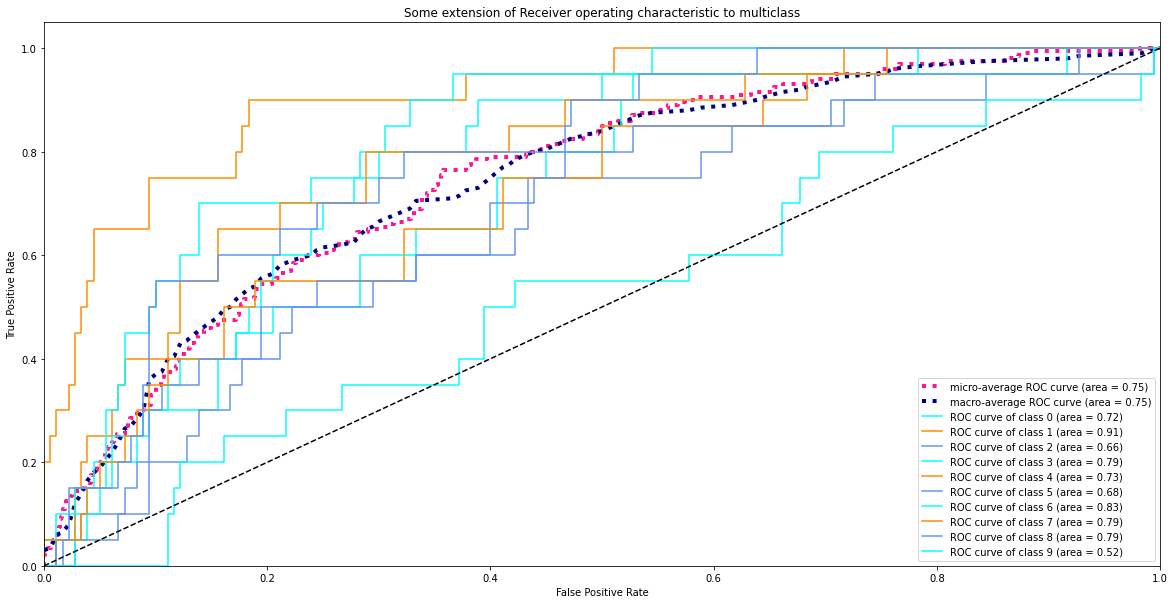

In [39]:
fpr_logreg, tpr_logreg, threshold_logreg, roc_auc_logreg=fpr_tpr_roc_auc(y_test_roc,y_pred_prob_logreg)

roc_plot(fpr_logreg, tpr_logreg, roc_auc_logreg)

#### ROC AUC Random Forest Classifier

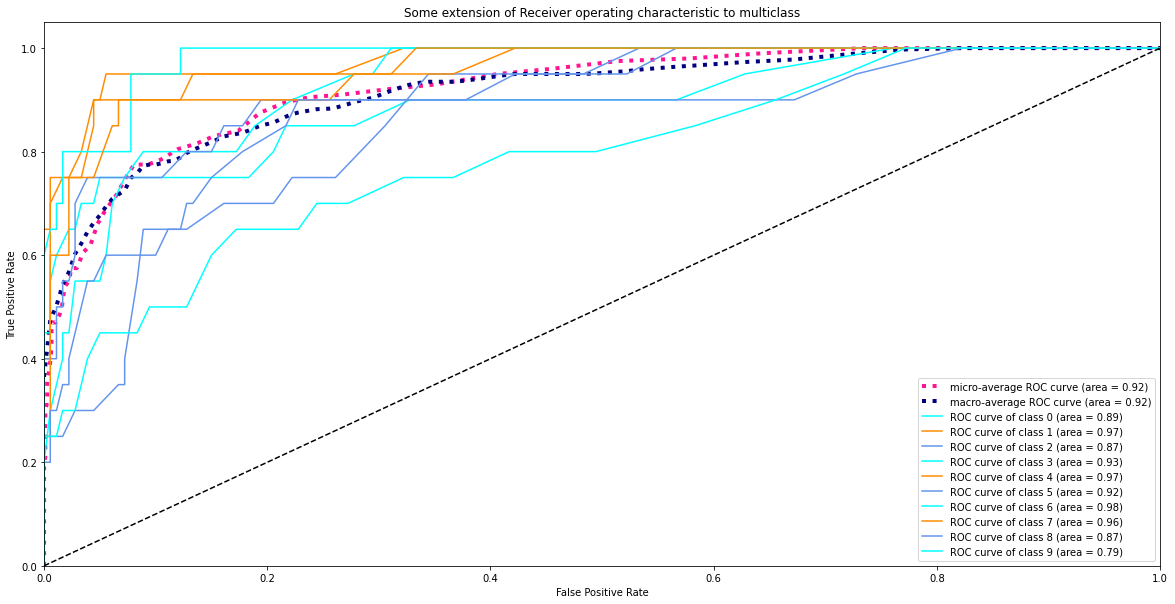

In [40]:
fpr_rfc, tpr_rfc, threshold_rfc,roc_auc_rfc=fpr_tpr_roc_auc(y_test_roc,y_pred_prob_rfc)

roc_plot(fpr_rfc, tpr_rfc, roc_auc_rfc)

#### ROC AUC SGD Classifier

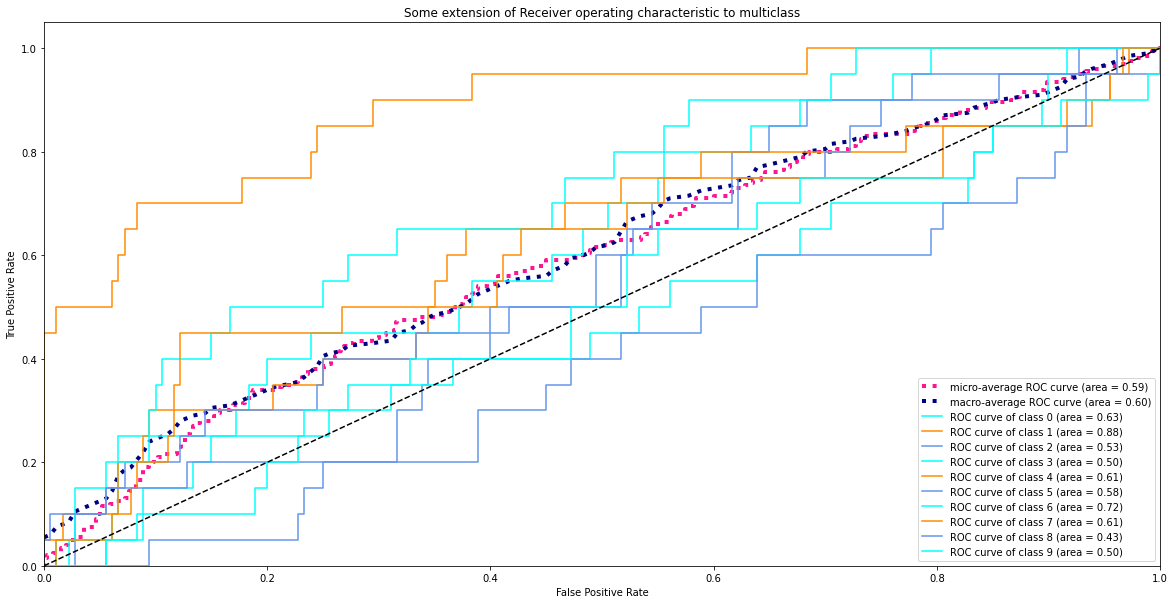

In [41]:
fpr_sgd, tpr_sgd, threshold_sgd,roc_auc_sgd=fpr_tpr_roc_auc(y_test_roc,y_pred_prob_SGD)

roc_plot(fpr_sgd, tpr_sgd, roc_auc_sgd)

#### ROC AUC KNN CLassifier

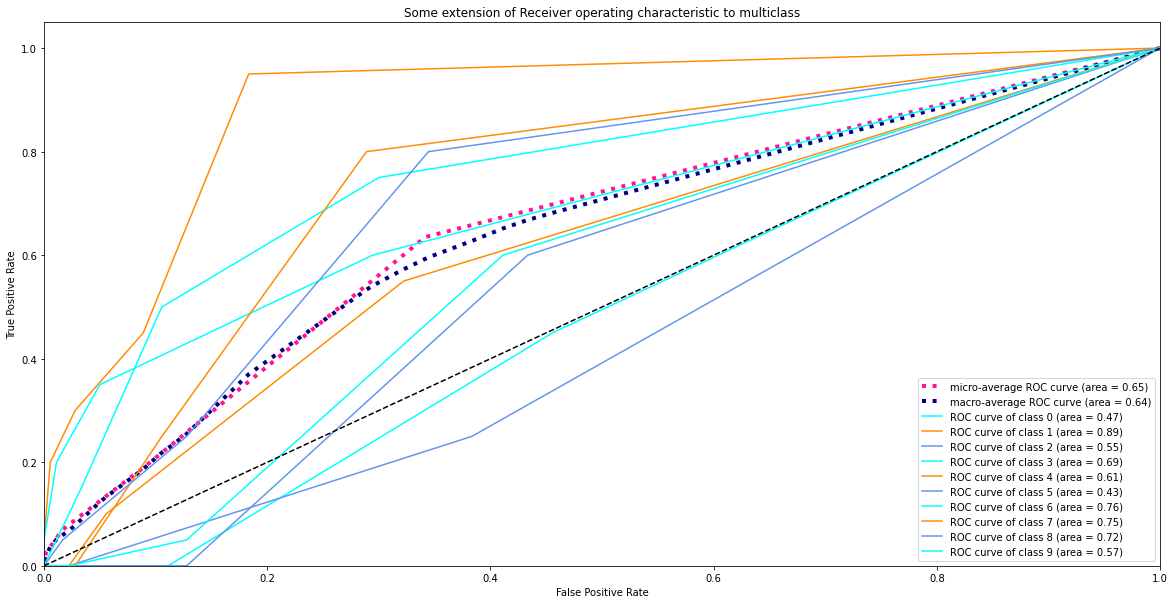

In [42]:
fpr_knn, tpr_knn, threshold_knn,roc_auc_knn=fpr_tpr_roc_auc(y_test_roc,y_pred_prob_knn)

roc_plot(fpr_knn, tpr_knn, roc_auc_knn)


#### ROC AUC CNN

In [43]:


y_pred_cnn = model.predict(x_test2)

y_pred_cnn = y_pred_cnn.argmax(axis=-1)
y_pred_cnn

array([9, 5, 0, 1, 8, 5, 5, 1, 0, 5, 6, 6, 3, 7, 1, 5, 7, 2, 2, 3, 3, 5,
       7, 7, 2, 3, 0, 6, 7, 9, 0, 7, 1, 3, 6, 6, 0, 0, 3, 6, 6, 6, 9, 7,
       2, 6, 2, 6, 8, 4, 8, 8, 5, 1, 4, 6, 5, 8, 3, 1, 0, 3, 4, 5, 0, 2,
       9, 0, 8, 0, 1, 3, 3, 4, 5, 2, 7, 2, 8, 2, 5, 8, 4, 6, 8, 5, 2, 1,
       5, 8, 1, 1, 4, 4, 5, 0, 4, 4, 4, 5, 8, 7, 8, 3, 6, 8, 8, 3, 8, 2,
       5, 8, 8, 7, 0, 3, 7, 3, 0, 2, 6, 1, 9, 9, 5, 5, 4, 9, 8, 0, 5, 0,
       3, 6, 5, 6, 8, 6, 6, 2, 0, 0, 6, 9, 3, 7, 4, 7, 2, 7, 1, 0, 3, 9,
       3, 9, 4, 1, 8, 5, 7, 6, 3, 5, 6, 6, 4, 2, 1, 1, 7, 3, 9, 2, 3, 4,
       6, 9, 7, 4, 4, 3, 3, 2, 3, 6, 3, 5, 8, 5, 1, 0, 5, 3, 4, 6, 8, 5,
       1, 9], dtype=int64)

In [44]:
y_train_cnn = Y_train2.argmax(axis=-1)
y_train_cnn

array([7, 3, 4, 4, 9, 2, 0, 7, 7, 2, 1, 7, 7, 2, 8, 6, 7, 1, 4, 2, 0, 3,
       1, 8, 9, 6, 7, 3, 0, 6, 4, 8, 2, 6, 3, 0, 4, 1, 9, 7, 4, 0, 6, 2,
       2, 1, 1, 6, 6, 2, 8, 3, 6, 3, 0, 1, 2, 6, 3, 8, 4, 6, 4, 8, 0, 6,
       9, 7, 7, 0, 2, 7, 6, 7, 5, 4, 0, 2, 7, 5, 8, 5, 8, 8, 1, 4, 5, 6,
       9, 1, 4, 1, 2, 3, 3, 4, 9, 2, 5, 6, 8, 4, 9, 9, 3, 4, 0, 7, 7, 8,
       9, 6, 3, 6, 3, 1, 5, 7, 7, 0, 3, 3, 9, 1, 7, 5, 8, 8, 4, 7, 5, 9,
       4, 4, 5, 5, 5, 2, 2, 4, 8, 8, 6, 5, 4, 5, 1, 1, 5, 7, 2, 8, 6, 3,
       8, 5, 2, 3, 7, 5, 3, 9, 5, 6, 8, 4, 3, 2, 7, 9, 6, 4, 6, 6, 4, 4,
       4, 8, 3, 8, 9, 2, 0, 7, 6, 9, 2, 8, 7, 3, 2, 2, 0, 3, 9, 0, 0, 7,
       2, 3, 1, 9, 6, 3, 5, 3, 1, 5, 9, 6, 4, 6, 7, 7, 5, 8, 2, 0, 3, 3,
       5, 9, 1, 2, 5, 1, 9, 7, 2, 5, 7, 4, 0, 9, 6, 8, 8, 6, 7, 6, 1, 0,
       5, 7, 4, 2, 2, 7, 3, 2, 2, 1, 5, 5, 2, 4, 6, 1, 1, 9, 4, 6, 2, 8,
       7, 5, 8, 6, 2, 5, 5, 5, 2, 4, 1, 5, 3, 5, 6, 0, 6, 9, 1, 7, 4, 7,
       2, 3, 1, 6, 2, 5, 7, 3, 3, 8, 2, 3, 5, 0, 5,

ROC AUC score: 0.8503203868852051


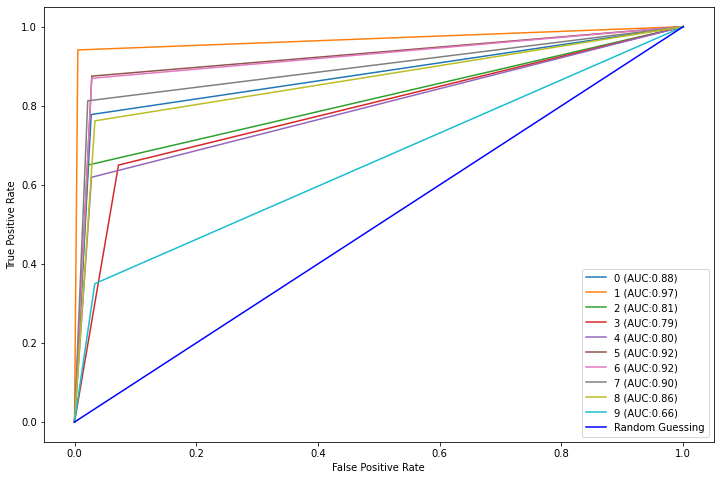

In [45]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

target= ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(y_test2, y_pred_cnn))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

In [46]:
# define a function that accepts a threshold and prints sensitivity and specificity
def evaluate_threshold(tpr, fpr,clf_threshold, threshold):
    return tpr[clf_threshold > threshold][-1], 1 - fpr[clf_threshold > threshold][-1]

In [47]:
evaluate_threshold(tpr_sgd[0], fpr_sgd[0], threshold_sgd[0], 0.2), evaluate_threshold(fpr_rfc[0], fpr_rfc[0], fpr_rfc[0], 0.8)

((0.15, 0.9111111111111111), (1.0, 0.0))

In [48]:
roc_auc_mean_logreg=[roc_auc_logreg[i] for i in range(10)]
roc_auc_mean_sgd=[roc_auc_sgd[i] for i in range(10)]
roc_auc_mean_rfc=[roc_auc_rfc[i] for i in range(10)]
roc_auc_mean_knn=[roc_auc_knn[i] for i in range(10)]
roc_auc_cnn= test_auc
mean(roc_auc_mean_logreg),mean(roc_auc_mean_sgd),mean(roc_auc_mean_rfc),mean(roc_auc_mean_knn),roc_auc_cnn



(0.7428055555555555,
 0.5982777777777778,
 0.9156805555555555,
 0.6438194444444445,
 0.9560125470161438)

### Precision, recall, f1-score

In [49]:
labels_mapping = {v: k for k, v in le_name_mapping.items()}
y_pred_cnn=np.vectorize(labels_mapping.get)(np.array(y_pred_cnn))
y_test2=np.vectorize(labels_mapping.get)(y_test2.argmax(axis=1))

In [50]:
report_logreg = metrics.classification_report(y_test, y_pred_class_logreg)
report_SGD = metrics.classification_report(y_test, y_pred_class_SGD)
report_rfc = metrics.classification_report(y_test, y_pred_class_rfc)
report_knn = metrics.classification_report(y_test, y_pred_class_knn)
report_cnn = metrics.classification_report(y_test2, y_pred_cnn)

print("report_logreg " +  "\n" + report_logreg,"report_SGD "  +  "\n" +  report_SGD,"report_rfc "  +  "\n" +  report_rfc,"report_knn "  +  "\n" +  report_knn,"report_cnn "   +  "\n"+report_cnn, sep = "\n")



report_logreg 
              precision    recall  f1-score   support

       blues       0.00      0.00      0.00        20
   classical       0.45      0.75      0.57        20
     country       0.22      0.20      0.21        20
       disco       0.25      0.25      0.25        20
      hiphop       0.22      0.20      0.21        20
        jazz       0.09      0.10      0.09        20
       metal       0.31      0.50      0.38        20
         pop       0.25      0.20      0.22        20
      reggae       0.36      0.20      0.26        20
        rock       0.18      0.15      0.16        20

    accuracy                           0.26       200
   macro avg       0.23      0.26      0.24       200
weighted avg       0.23      0.26      0.24       200

report_SGD 
              precision    recall  f1-score   support

       blues       0.08      0.05      0.06        20
   classical       0.20      0.40      0.26        20
     country       0.11      0.15      0.12        

### Credit Card Usage Dataset

In [51]:
data = pd.read_csv('creditcard.csv')
data

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [52]:
n_classes=2

X =  data.drop(["Class"],axis = 1)
y = data["Class"]


In [53]:
data

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [54]:
X

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00


In [55]:
y

0         0
1         0
2         0
3         0
4         0
         ..
284802    0
284803    0
284804    0
284805    0
284806    0
Name: Class, Length: 284807, dtype: int64

In [56]:
list(y.drop_duplicates().values)

[0, 1]

### Split dataset

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.2,random_state = 56)
y_train_roc = label_binarize(y_train, classes=[0,1])
y_test_roc = label_binarize(y_test, classes=[0,1])
cv = StratifiedKFold(n_splits=10, shuffle = True, random_state = 56)

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y_test)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{0: 0, 1: 1}


In [58]:
y_test

133104    0
112551    0
118326    0
126822    0
86876     0
         ..
66978     0
35072     0
280208    0
59985     0
164639    0
Name: Class, Length: 56962, dtype: int64

In [59]:
y_test_roc= np.hstack((1- y_test_roc, y_test_roc))
y_test_roc



array([[1, 0],
       [1, 0],
       [1, 0],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]])

### Logistic Regression

In [60]:
clf_logreg = LogisticRegression()
clf_logreg.fit(X_train, y_train)
y_pred_class_logreg = cross_val_predict(clf_logreg, X_test, y_test, cv = cv)
y_pred_prob_logreg = cross_val_predict(clf_logreg, X_test, y_test, cv = cv, method="predict_proba")

### SGD Classifier

In [61]:
clf_SGD = SGDClassifier()
clf_SGD.fit(X_train, y_train)
y_pred_class_SGD = cross_val_predict(clf_SGD, X_test, y_test, cv = cv)
y_pred_prob_SGD = cross_val_predict(clf_SGD, X_test, y_test, cv = cv, method="decision_function")

### Random Forest Classifier

In [62]:
clf_rfc = RandomForestClassifier()
clf_rfc.fit(X_train, y_train)
y_pred_class_rfc = cross_val_predict(clf_rfc, X_test, y_test, cv = cv)
y_pred_prob_rfc = cross_val_predict(clf_rfc, X_test, y_test, cv = cv, method="predict_proba")

### K Neighbors Classifier

In [63]:
clf_knn = KNeighborsClassifier()
clf_knn.fit(X_train, y_train)
y_pred_class_knn = cross_val_predict(clf_knn, X_test, y_test, cv = cv)
y_pred_prob_knn = cross_val_predict(clf_knn, X_test, y_test, cv = cv, method="predict_proba")

### Neural network
#### Feature extraction

In [64]:
from tensorflow import keras

# from sklearn.preprocessing import LabelEncoder
# convert = LabelEncoder()
# y2 = convert.fit_transform(y)

from sklearn.preprocessing import LabelBinarizer # one hot encoding
label_as_binary = LabelBinarizer()
y2 = label_as_binary.fit_transform(y)

In [65]:
y2

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [66]:
# scaling features
from sklearn.preprocessing import StandardScaler
fit = StandardScaler()
X2 = fit.fit_transform(np.array(X, dtype=float))

In [67]:
X2

array([[-1.99658302, -0.69424232, -0.04407492, ...,  0.33089162,
        -0.06378115,  0.24496426],
       [-1.99658302,  0.60849633,  0.16117592, ..., -0.02225568,
         0.04460752, -0.34247454],
       [-1.99656197, -0.69350046, -0.81157783, ..., -0.13713686,
        -0.18102083,  1.16068593],
       ...,
       [ 1.6419735 ,  0.98002374, -0.18243372, ...,  0.01103672,
        -0.0804672 , -0.0818393 ],
       [ 1.6419735 , -0.12275539,  0.32125034, ...,  0.26960398,
         0.31668678, -0.31324853],
       [ 1.64205773, -0.27233093, -0.11489898, ..., -0.00598394,
         0.04134999,  0.51435531]])

In [68]:
X_train2, x_test2, Y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=56)

In [69]:
print(X_train2.shape, Y_train2.shape)

(227845, 30) (227845, 1)


In [70]:
print(x_test2.shape, y_test2.shape)

(56962, 30) (56962, 1)


#### Building model

In [71]:
# CNN
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential()

model.add(Dense(512,input_shape=(X_train2.shape[1],), activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(256,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(64,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1,activation='sigmoid'))

In [72]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 512)               15872     
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 64)               

In [73]:

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

In [74]:
loss_object = keras.losses.BinaryCrossentropy()
optimizer = keras.optimizers.Adam()

model.compile(
    loss=loss_object,
    optimizer=optimizer,
    metrics=METRICS)

In [75]:
earlystop = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=10,min_delta=0.0001)
modelcheck = ModelCheckpoint('best_model.hdf5',monitor='val_accuracy',verbose=1,save_best_only=True,mode='max')

In [76]:
history = model.fit(X_train2, Y_train2,
                    validation_data=(x_test2, y_test2),
                    epochs=200,
                    callbacks=[earlystop,modelcheck],
                    batch_size=128)

Epoch 1/200
1778/1781 [============================>.] - ETA: 0s - loss: 0.0074 - tp: 269.0000 - fp: 157.0000 - tn: 227041.0000 - fn: 117.0000 - accuracy: 0.9988 - precision: 0.6315 - recall: 0.6969 - auc: 0.9213

In [77]:
# history.history

1781/1781 - 3s - loss: 0.0065 - tp: 74.0000 - fp: 5.0000 - tn: 56852.0000 - fn: 31.0000 - accuracy: 0.9994 - precision: 0.9367 - recall: 0.7048 - auc: 0.9426 - 3s/epoch - 2ms/step
7121/7121 - 11s - loss: 0.0014 - tp: 274.0000 - fp: 7.0000 - tn: 227451.0000 - fn: 113.0000 - accuracy: 0.9995 - precision: 0.9751 - recall: 0.7080 - auc: 0.9870 - 11s/epoch - 2ms/step


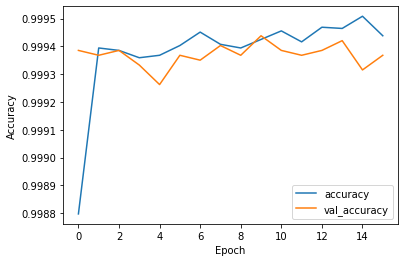

In [78]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

test_loss, test_tp, test_fp, test_tn, test_fn, test_acc, test_precision, test_recall, test_auc = model.evaluate(x_test2,  y_test2, verbose=2)
train_loss, train_tp, train_fp, train_tn, train_fn, train_acc, train_precision, train_recall, train_auc = model.evaluate(X_train2,  Y_train2, verbose=2)

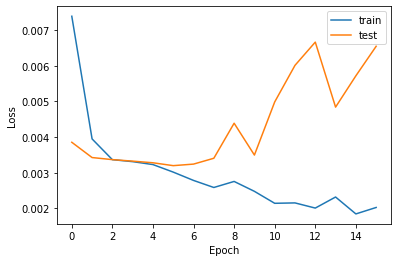

In [79]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [80]:
from sklearn.base import BaseEstimator
import numpy as np

class BaseClassifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

base_clf = BaseClassifier()
cross_val_score(base_clf, X_train, y_train, cv=10, scoring="accuracy").mean()

0.998270756744162

### Accuracy

In [81]:
acc_logreg = cross_val_score(clf_logreg, X_test, y_test, cv = cv, scoring = 'accuracy').mean()
acc_SGD = cross_val_score(clf_SGD, X_test, y_test, cv = cv, scoring = 'accuracy').mean()
acc_rfc = cross_val_score(clf_rfc, X_test, y_test, cv = cv, scoring = 'accuracy').mean()
acc_knn = cross_val_score(clf_knn, X_test, y_test, cv = cv, scoring = 'accuracy').mean()
acc_cnn = test_acc

In [82]:
acc_logreg, acc_SGD, acc_rfc, acc_knn, acc_cnn

(0.9988413229513661,
 0.9981917781978688,
 0.9994382145738051,
 0.9982795560150917,
 0.9993680119514465)

### Log loss

In [83]:
logloss_logreg = cross_val_score(clf_logreg, X_test, y_test, cv = cv, scoring = 'neg_log_loss').mean()
logloss_rfc = cross_val_score(clf_rfc, X_test, y_test, cv = cv, scoring = 'neg_log_loss').mean()
logloss_knn = cross_val_score(clf_knn, X_test, y_test, cv = cv, scoring = 'neg_log_loss').mean()

from sklearn.calibration import CalibratedClassifierCV

new_clf_SGD = CalibratedClassifierCV(clf_SGD)
new_clf_SGD.fit(X_train, y_train)
logloss_SGD = cross_val_score(new_clf_SGD, X_test, y_test, cv = cv, scoring = 'neg_log_loss').mean()
logloss_cnn = test_loss

In [84]:
-logloss_logreg, -logloss_SGD, -logloss_rfc, -logloss_knn, logloss_cnn

(0.009996196041482882,
 0.012672853125119754,
 0.00803390353096738,
 0.05416232381958798,
 0.006544811185449362)

### ROC AUC

In [85]:
def fpr_tpr_roc_auc(y_binarized, y_pred_prob):
    fpr = dict()
    tpr = dict()
    threshold = dict()
    roc_auc = dict()
    for i in range(2):
        fpr[i], tpr[i], threshold[i] = roc_curve(y_binarized[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(y_binarized.ravel(), y_pred_prob.ravel())
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    return fpr, tpr, threshold, roc_auc

In [86]:
def roc_plot(fpr, tpr,roc_auc):

    plt.figure(figsize=(20,10))
    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )
    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
        color="navy",
        linestyle=":",
        linewidth=4,
    )
    colors = cycle(["aqua", "darkorange", "cornflowerblue"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
        )

    plt.plot([0, 1], [0, 1], "k--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Some extension of Receiver operating characteristic to multiclass")
    plt.legend(loc="lower right")
    plt.show()

#### ROC AUC Logistic Regression

In [87]:
y_test_roc

array([[1, 0],
       [1, 0],
       [1, 0],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]])

In [88]:
y_pred_prob_logreg

array([[9.99994382e-01, 5.61774469e-06],
       [9.99967750e-01, 3.22495891e-05],
       [9.99981410e-01, 1.85898672e-05],
       ...,
       [9.99999965e-01, 3.49973666e-08],
       [9.95185629e-01, 4.81437073e-03],
       [9.99994080e-01, 5.91978212e-06]])

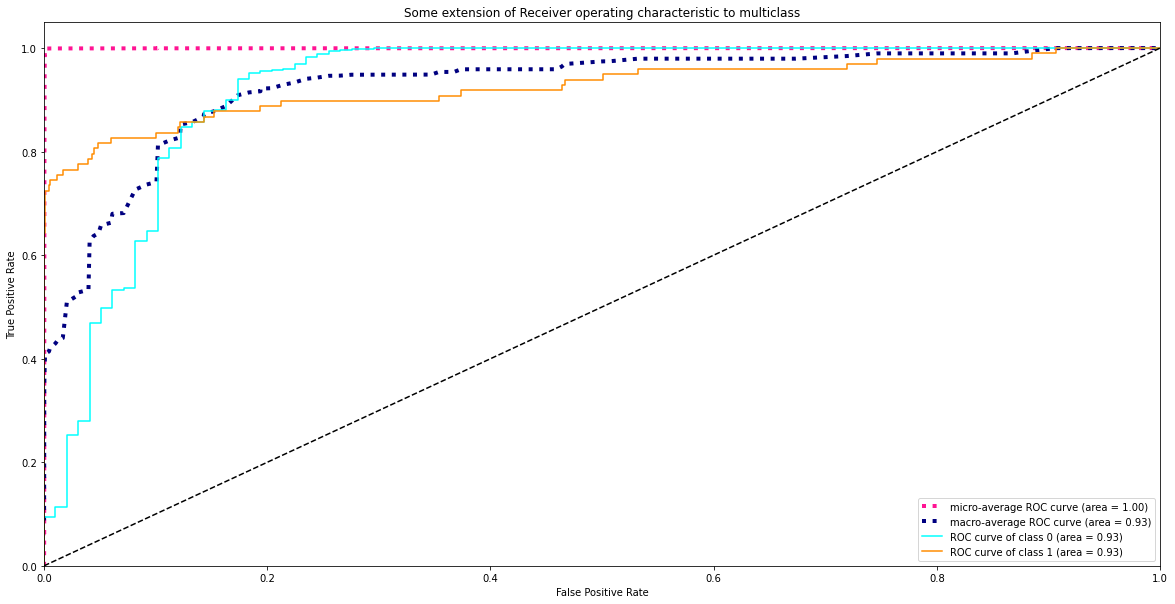

In [89]:
fpr_logreg, tpr_logreg, threshold_logreg, roc_auc_logreg=fpr_tpr_roc_auc(y_test_roc,y_pred_prob_logreg)

roc_plot(fpr_logreg, tpr_logreg, roc_auc_logreg)

#### ROC AUC Random Forest Classifier

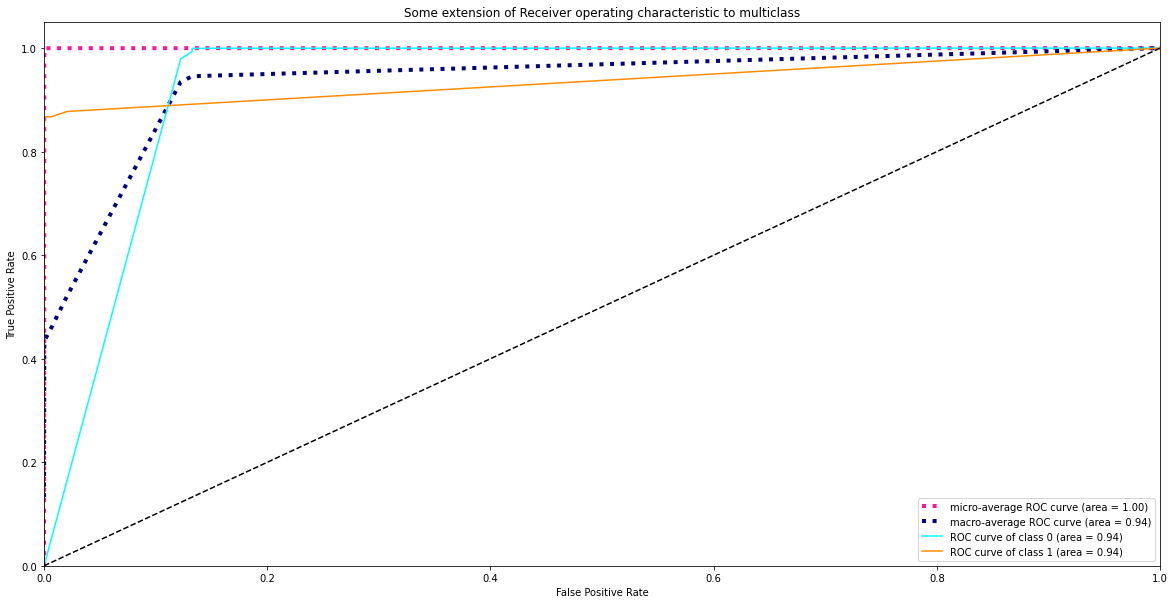

In [90]:
fpr_rfc, tpr_rfc, threshold_rfc,roc_auc_rfc=fpr_tpr_roc_auc(y_test_roc,y_pred_prob_rfc)

roc_plot(fpr_rfc, tpr_rfc, roc_auc_rfc)

#### ROC AUC SGD Classifier

In [91]:
#fpr_sgd, tpr_sgd, threshold_sgd,roc_auc_sgd=fpr_tpr_roc_auc(y_test_roc,y_pred_prob_SGD)

#roc_plot(fpr_sgd, tpr_sgd, roc_auc_sgd)

#### ROC AUC KNN CLassifier

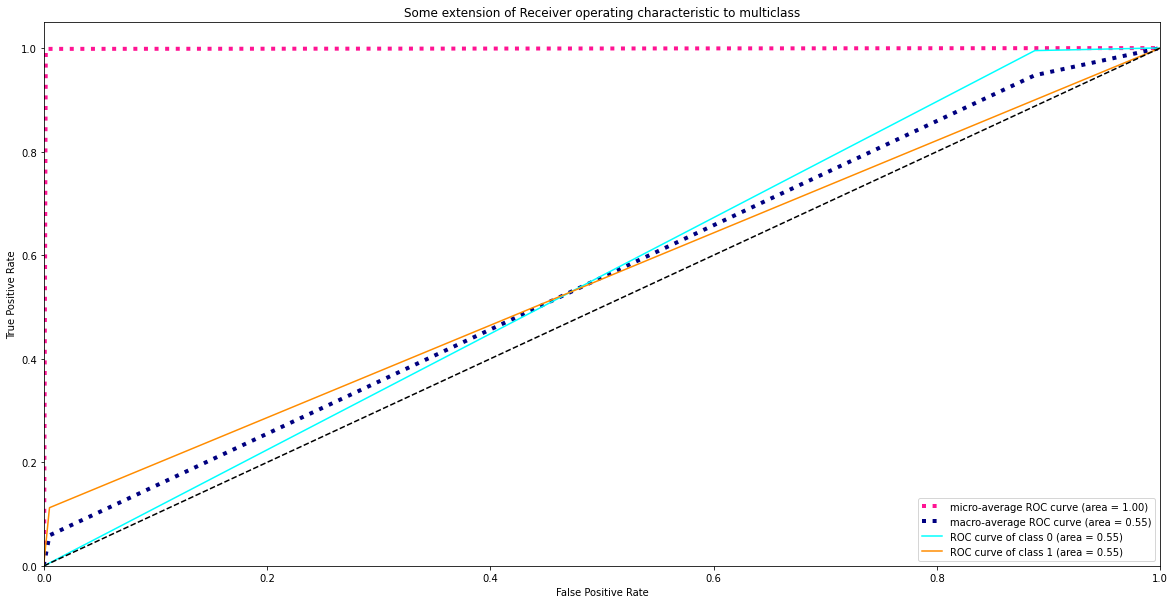

In [92]:
fpr_knn, tpr_knn, threshold_knn,roc_auc_knn=fpr_tpr_roc_auc(y_test_roc,y_pred_prob_knn)

roc_plot(fpr_knn, tpr_knn, roc_auc_knn)


#### ROC AUC CNN

In [93]:


y_pred_cnn = model.predict(x_test2)

y_pred_cnn = y_pred_cnn.argmax(axis=-1)
# y_pred_cnn

In [94]:
y_train_cnn = Y_train2.argmax(axis=-1)
# y_train_cnn

In [95]:
y_test2=label_binarize(y_test2, classes=[0,1])
y_test2= np.hstack((1-y_test2, y_test2))
y_test2

array([[1, 0],
       [1, 0],
       [1, 0],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]])

In [96]:
y_pred_cnn=label_binarize(y_pred_cnn, classes=[0,1])
y_pred_cnn= np.hstack((1-y_pred_cnn, y_pred_cnn))
y_pred_cnn

array([[1, 0],
       [1, 0],
       [1, 0],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]])

In [97]:
y_pred_cnn

array([[1, 0],
       [1, 0],
       [1, 0],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]])

ROC AUC score: 0.5


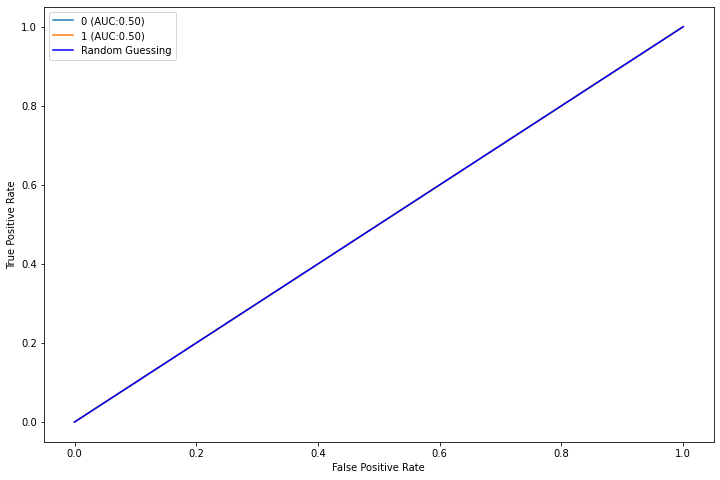

In [98]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

target= ['0', '1']
# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(y_test2, y_pred_cnn))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

In [99]:
# define a function that accepts a threshold and prints sensitivity and specificity
def evaluate_threshold(tpr, fpr,clf_threshold, threshold):
    return tpr[clf_threshold > threshold][-1], 1 - fpr[clf_threshold > threshold][-1]

In [100]:
evaluate_threshold(tpr_sgd[0], fpr_sgd[0], threshold_sgd[0], 0.2), evaluate_threshold(fpr_rfc[0], fpr_rfc[0], fpr_rfc[0], 0.8)

((0.15, 0.9111111111111111), (1.0, 0.0))

In [101]:
roc_auc_mean_logreg=[roc_auc_logreg[i] for i in range(2)]
roc_auc_mean_sgd=[roc_auc_sgd[i] for i in range(2)]
roc_auc_mean_rfc=[roc_auc_rfc[i] for i in range(2)]
roc_auc_mean_knn=[roc_auc_knn[i] for i in range(2)]
roc_auc_cnn= test_auc
mean(roc_auc_mean_logreg),mean(roc_auc_mean_sgd),mean(roc_auc_mean_rfc),mean(roc_auc_mean_knn),roc_auc_cnn



(0.9254153124389879,
 0.7551388888888888,
 0.937309696318032,
 0.5537144479344918,
 0.9425827860832214)

### Precision, recall, f1-score

In [102]:
labels_mapping = {v: k for k, v in le_name_mapping.items()}
y_pred_cnn=np.vectorize(labels_mapping.get)(np.array(y_pred_cnn))
y_test2=np.vectorize(labels_mapping.get)(y_test2.argmax(axis=1))


In [103]:
y_test2=label_binarize(y_test2, classes=[0,1])
y_test2= np.hstack((1-y_test2, y_test2))
y_test2

array([[1, 0],
       [1, 0],
       [1, 0],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]])

In [104]:
report_logreg = metrics.classification_report(y_test, y_pred_class_logreg)
report_SGD = metrics.classification_report(y_test, y_pred_class_SGD)
report_rfc = metrics.classification_report(y_test, y_pred_class_rfc)
report_knn = metrics.classification_report(y_test, y_pred_class_knn)
report_cnn = metrics.classification_report(y_test2, y_pred_cnn)

print("report_logreg " +  "\n" + report_logreg,"report_SGD "  +  "\n" +  report_SGD,"report_rfc "  +  "\n" +  report_rfc,"report_knn "  +  "\n" +  report_knn,"report_cnn "   +  "\n"+report_cnn, sep = "\n")






report_logreg 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.65      0.69      0.67        98

    accuracy                           1.00     56962
   macro avg       0.83      0.85      0.84     56962
weighted avg       1.00      1.00      1.00     56962

report_SGD 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.00      0.00      0.00        98

    accuracy                           1.00     56962
   macro avg       0.50      0.50      0.50     56962
weighted avg       1.00      1.00      1.00     56962

report_rfc 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.88      0.76      0.81        98

    accuracy                           1.00     56962
   macro avg       0.94      0.88      0.91     56962
weighted avg       1.00      1.00  